# **DEEP LEARNING MODELING TO PREDICT SAMSUNG'S STOCK PRICE**

- **Motivation**: Occasionally, I invest in stocks with my pocket money. One day, a sudden thought occurred to me while engaging in stock trading: "What if I were to develop deep learning models to guide my investments? Would I be able to make a profit? Would it be better than investing without it?" With the aim of putting this idea into action, I embarked on this project.

<br>

- **Question**: Will Samsung's stock price go up or down?

<br>

- **Main Idea / Goal**: Through the utilization of LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) models, this project seeks to harness the power of deep learning techniques to predict Samsung's stock performance. The ultimate goal is to answer my question and provide a reliable tool that empowers investors with actionable insights, aiding them in navigating the dynamic landscape of financial markets more effectively and making informed decisions to optimize their investment portfolios.



# **SETUP / BASICS**

## Importing libraries

- This section imports necessary libraries and sets up the environment for the stock price prediction project. It includes imports for data manipulation, visualization, machine learning models from both TensorFlow and scikit-learn.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set_theme(style = 'whitegrid', palette = 'pastel')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import EarlyStopping

## Reading the file

In [ ]:
# Reading CSV file
dataset = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data/Samsung.csv')

In [ ]:
df = dataset.copy()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2019,39400,39400,38550,38750,33776.15234,7847664
1,1/3/2019,38300,38550,37450,37600,32773.76953,12471493
2,1/4/2019,37450,37600,36850,37450,32643.01758,14108958
3,1/7/2019,38000,38900,37800,38750,33776.15234,12748997
4,1/8/2019,38000,39200,37950,38100,33209.58594,12756554
...,...,...,...,...,...,...,...
1294,4/3/2024,84300,85000,83500,84100,84100.00000,30493347
1295,4/4/2024,85200,85500,84300,85300,85300.00000,25248934
1296,4/5/2024,84500,85000,83800,84500,84500.00000,18883752
1297,4/8/2024,85200,86000,84500,84500,84500.00000,18953232


## Quick look

In [ ]:
# Checker function for easier identification of data types and unique values
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check

check(df)

,column,dtypes,nunique,sum_null
0,Date,object,1299,0
1,Open,int64,464,0
2,High,int64,458,0
3,Low,int64,455,0
4,Close,int64,472,0
5,Adj Close,float64,935,0
6,Volume,int64,1287,0


In [ ]:
# Changing the data type and setting date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,39400,39400,38550,38750,33776.15234,7847664
2019-01-03,38300,38550,37450,37600,32773.76953,12471493
2019-01-04,37450,37600,36850,37450,32643.01758,14108958
2019-01-07,38000,38900,37800,38750,33776.15234,12748997
2019-01-08,38000,39200,37950,38100,33209.58594,12756554
...,...,...,...,...,...,...
2024-04-03,84300,85000,83500,84100,84100.00000,30493347
2024-04-04,85200,85500,84300,85300,85300.00000,25248934
2024-04-05,84500,85000,83800,84500,84500.00000,18883752


# **PREPROCESSING**

## Defining training size

In [ ]:
# 80% of my data will be used to train.
train_size = int(df.shape[0] * 0.80)
print("The training set size is : {}".format(train_size))
print("The testing set size is : {}".format(df.shape[0] - train_size))

The training set size is : 1039
The testing set size is : 260


## Visualization of the split

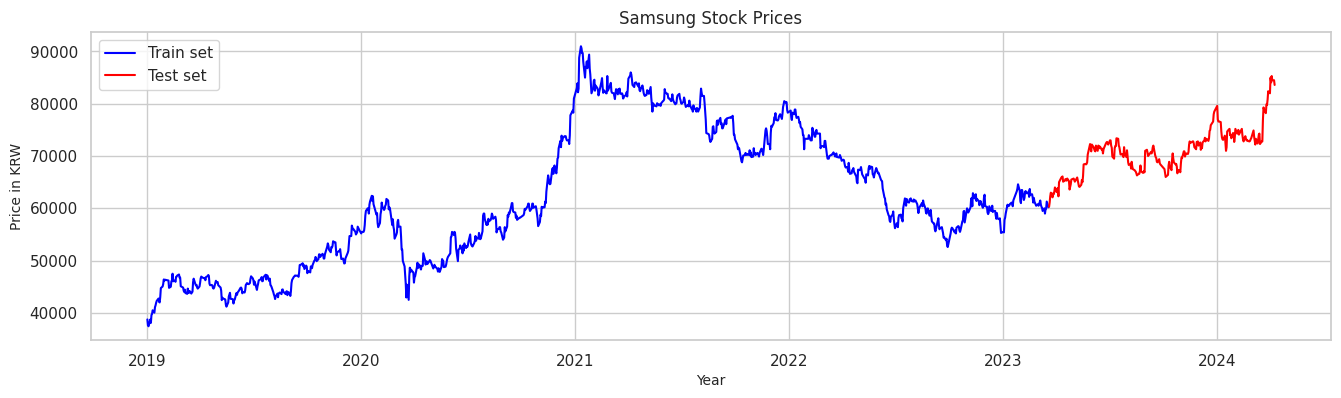

In [ ]:
plt.figure(figsize=(16,4))

# Plotting the training set (blue)
plt.plot(df[:train_size]['Close'], color='Blue', label='Train set')
# Plotting the test set (red)
plt.plot(df[train_size:]['Close'], color='red', label='Test set')

plt.legend()
plt.title('Samsung Stock Prices')
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Price in KRW', fontsize = 10)
plt.show()

## Scaling data

In [ ]:
# Using MinMaxScaler to scale the data
data = df.filter(['Close']).values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.02427638],
       [0.00280112],
       [0.        ],
       ...,
       [0.87861811],
       [0.87861811],
       [0.86181139]])

## Train / test split

In [ ]:
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size - 60: , :]

# Appending x_train (With 60 time steps) , y_train
x_train = []
y_train = []

for i in range (60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

# Appending x_test (With 60 time steps) , y_test
x_test = []
y_test = data[train_size:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array to use for modeling
x_train, y_train , x_test = np.array(x_train) , np.array(y_train) , np.array(x_test)

# Reshape the data to be [sample count, time steps, features] which is required for LSTM and GRU
x_train = np.reshape(x_train , (x_train.shape[0], x_train.shape[1] , 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(979, 60, 1)
(979,)
(260, 60, 1)
(260, 1)


# **LSTM MODEL**

## Building and training the model

In [ ]:
# Build the LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(64, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model_LSTM.add(LSTM(64, return_sequences=False))
model_LSTM.add(Dense(32))
model_LSTM.add(Dense(16))
model_LSTM.add(Dense(1))

# Compile the model
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model_LSTM.fit(x_train, y_train, epochs= 200, batch_size= 32)


Epoch 1/200
31/31 [==============================] - 8s 55ms/step - loss: 0.0284
Epoch 2/200
31/31 [==============================] - 2s 55ms/step - loss: 0.0025
Epoch 3/200
31/31 [==============================] - 2s 55ms/step - loss: 0.0017
Epoch 4/200
31/31 [==============================] - 2s 54ms/step - loss: 0.0017
Epoch 5/200
31/31 [==============================] - 2s 79ms/step - loss: 0.0017
Epoch 6/200
31/31 [==============================] - 3s 80ms/step - loss: 0.0015
Epoch 7/200
31/31 [==============================] - 2s 55ms/step - loss: 0.0016
Epoch 8/200
31/31 [==============================] - 2s 55ms/step - loss: 0.0015
Epoch 9/200
31/31 [==============================] - 2s 54ms/step - loss: 0.0013
Epoch 10/200
31/31 [==============================] - 2s 55ms/step - loss: 0.0013
Epoch 11/200
31/31 [==============================] - 2s 54ms/step - loss: 0.0012
Epoch 12/200
31/31 [==============================] - 2s 69ms/step - loss: 0.0012
Epoch 13/200
31/31 [=====

## Predictions

In [ ]:
# Get the LSTM model's predicted price values (y_pred_LSTM)
y_pred_LSTM = model_LSTM.predict(x_test)
y_pred_LSTM = scaler.inverse_transform(y_pred_LSTM)
print( y_pred_LSTM.T )

9/9 [==============================] - 1s 18ms/step
[[60096.29  60190.363 60972.457 62153.133 62843.84  61949.637 62765.78
  62557.633 63065.54  63859.887 62944.414 63476.574 63761.727 62158.625
  64901.746 65521.316 65702.69  65806.24  65907.36  64891.582 65151.41
  65439.41  65322.812 65126.617 65538.47  65005.754 63416.34  63976.12
  64443.45  65327.727 65491.996 65181.91  64895.47  65719.22  65071.664
  64402.887 64030.44  63939.1   64339.723 65229.168 64787.383 66026.1
  68216.16  68193.97  68120.05  68249.1   68562.61  70112.19  72091.4
  70974.266 70609.41  72024.43  71344.125 70701.33  70663.4   71810.97
  70625.44  71812.24  71563.41  71170.88  71528.06  70846.62  71128.39
  70141.81  71078.08  71283.414 72108.03  72235.41  72340.53  72021.99
  71855.41  72723.516 72623.54  71589.63  71291.234 69520.12  69266.31
  71351.445 71548.48  71540.2   73136.47  72851.66  71537.26  71388.14
  70654.42  69990.12  70148.6   69696.27  69519.73  71513.05  70153.12
  69469.98  70888.41  694

## Scores

In [ ]:
mae = mean_absolute_error(y_test, y_pred_LSTM)
mse = mean_squared_error(y_test, y_pred_LSTM)
r2 = r2_score(y_test, y_pred_LSTM)
print("MAE: {}".format(mae))
print("MSE: {}".format(mse))
print("RMSE: {}".format(np.sqrt(mse)))
print("R2 Score: {}".format(r2))


MAE: 759.4848407451923
MSE: 1078691.6510655917
RMSE: 1038.6008141078996
R2 Score: 0.9451129997054254


## Visualization

In [ ]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]
print(train_dates)
print(test_dates)

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
               '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
               '2023-03-17', '2023-03-20'],
              dtype='datetime64[ns]', name='Date', length=1039, freq=None)
DatetimeIndex(['2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
               '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
               '2023-03-31', '2023-04-03',
               ...
               '2024-03-27', '2024-03-28', '2024-03-29', '2024-04-01',
               '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05',
               '2024-04-08', '2024-04-09'],
              dtype='datetime64[ns]', name='Date', length=260, freq=None)


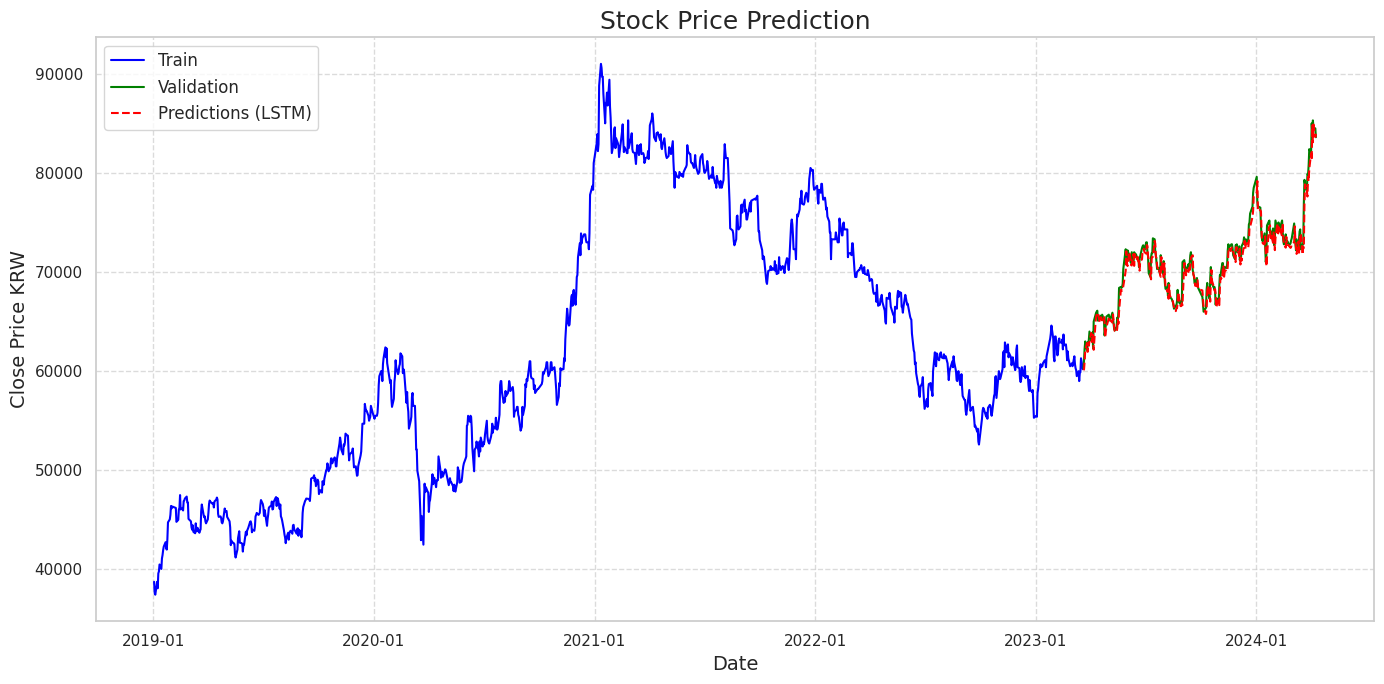

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(train_dates, df.loc[train_dates,'Close'], color='blue', label='Train')
ax.plot(test_dates, df.loc[test_dates,'Close'], color='green', label='Validation')
ax.plot(test_dates, y_pred_LSTM, color='red', linestyle = '--' ,label='Predictions (LSTM)')

plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price KRW', fontsize=14)

plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

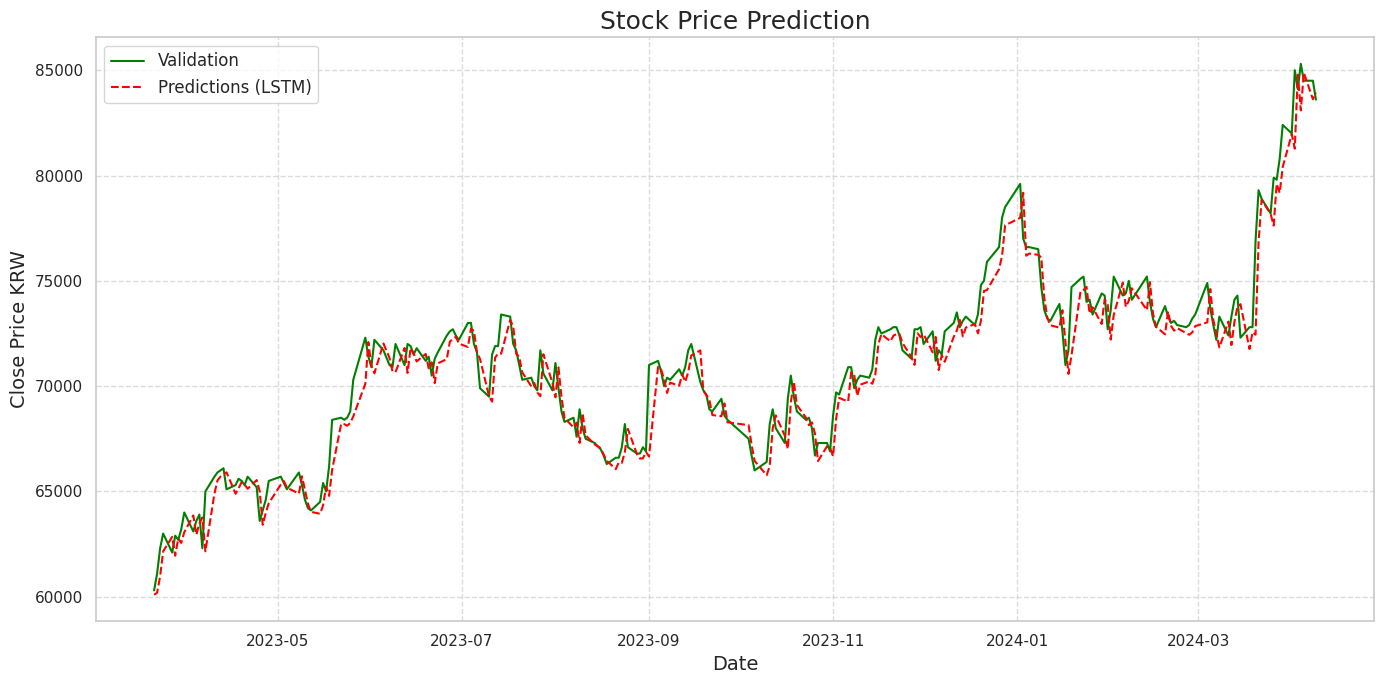

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(test_dates, df.loc[test_dates,'Close'], color='green', label='Validation')
ax.plot(test_dates, y_pred_LSTM, color='red', linestyle = '--' ,label='Predictions (LSTM)')

plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price KRW', fontsize=14)

plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

# **GRU MODEL**

## Building and training the model

In [ ]:
# Clearing Session
tf.keras.backend.clear_session()

# Building GRU model
model_GRU=Sequential()
model_GRU.add(GRU(32,return_sequences=True,input_shape=(x_train.shape[1],1)))
model_GRU.add(GRU(32,return_sequences=True))
model_GRU.add(GRU(32))
model_GRU.add(Dropout(0.20))
model_GRU.add(Dense(1))

# Compiling the model
model_GRU.compile(loss='mean_squared_error',optimizer='adam')

# Fitting the model
GRU = model_GRU.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
31/31 [==============================] - 10s 109ms/step - loss: 0.0418 - val_loss: 5043437568.0000
Epoch 2/200
31/31 [==============================] - 2s 72ms/step - loss: 0.0067 - val_loss: 5043431936.0000
Epoch 3/200
31/31 [==============================] - 2s 73ms/step - loss: 0.0049 - val_loss: 5043430400.0000
Epoch 4/200
31/31 [==============================] - 3s 85ms/step - loss: 0.0044 - val_loss: 5043430400.0000
Epoch 5/200
31/31 [==============================] - 3s 103ms/step - loss: 0.0038 - val_loss: 5043428352.0000
Epoch 6/200
31/31 [==============================] - 2s 73ms/step - loss: 0.0035 - val_loss: 5043433472.0000
Epoch 7/200
31/31 [==============================] - 2s 73ms/step - loss: 0.0034 - val_loss: 5043432448.0000
Epoch 8/200
31/31 [==============================] - 2s 73ms/step - loss: 0.0035 - val_loss: 5043434496.0000
Epoch 9/200
31/31 [==============================] - 2s 71ms/step - loss: 0.0032 - val_loss: 5043430912.0000
Epoch 10/200
31/

## Predictions

In [ ]:
# Get the models predicted price values
y_pred_GRU = model_GRU.predict(x_test)
y_pred_GRU = scaler.inverse_transform(y_pred_GRU)
print(y_pred_GRU.T)

## Scores

In [ ]:
mae = mean_absolute_error(y_test, y_pred_GRU)
mse = mean_squared_error(y_test, y_pred_GRU)
r2 = r2_score(y_test, y_pred_GRU)

print("MAE: {}".format(mae))
print("RMSE: {}".format(np.sqrt(mse)))
print("MSE: {}".format(mse))
print("R2 Score: {}".format(r2))

MAE: 733.180108173077
RMSE: 964.6745753820072
MSE: 930597.0363884559
R2 Score: 0.952648488787388


## Visualization

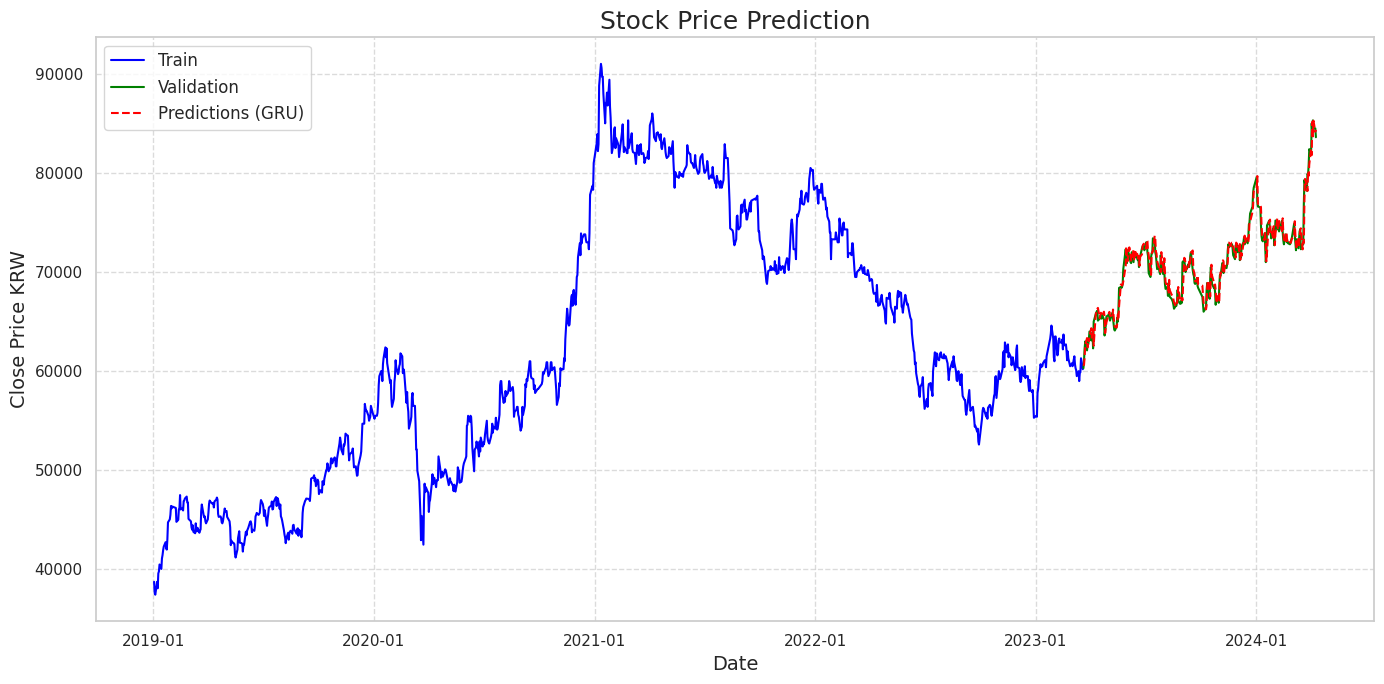

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(train_dates, df.loc[train_dates,'Close'], color='blue', label='Train')
ax.plot(test_dates, df.loc[test_dates,'Close'], color='green', label='Validation')
ax.plot(test_dates, y_pred_GRU, color='red', linestyle = '--' ,label='Predictions (GRU)')

plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price KRW', fontsize=14)

plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

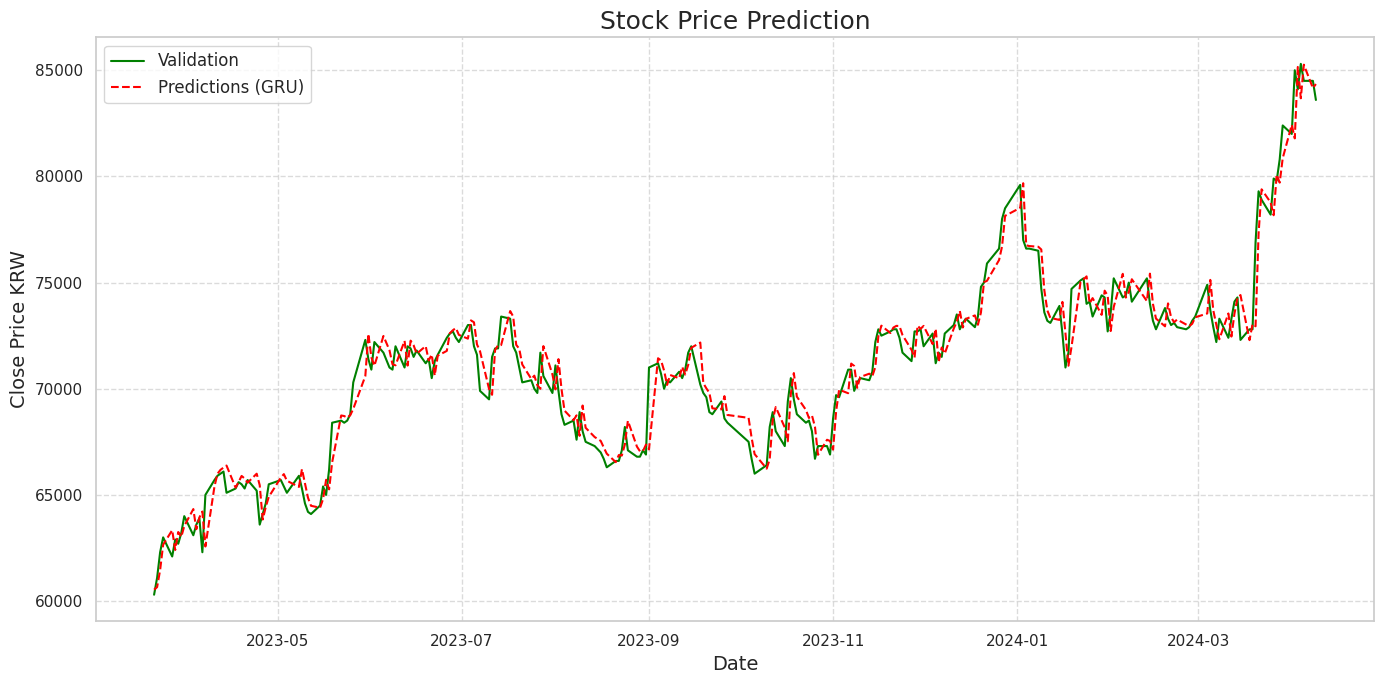

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(test_dates, df.loc[test_dates,'Close'], color='green', label='Validation')
ax.plot(test_dates, y_pred_GRU, color='red', linestyle = '--' ,label='Predictions (GRU)')

plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price KRW', fontsize=14)

plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

# COMPARING TWO MODELS

## Prediction comparison

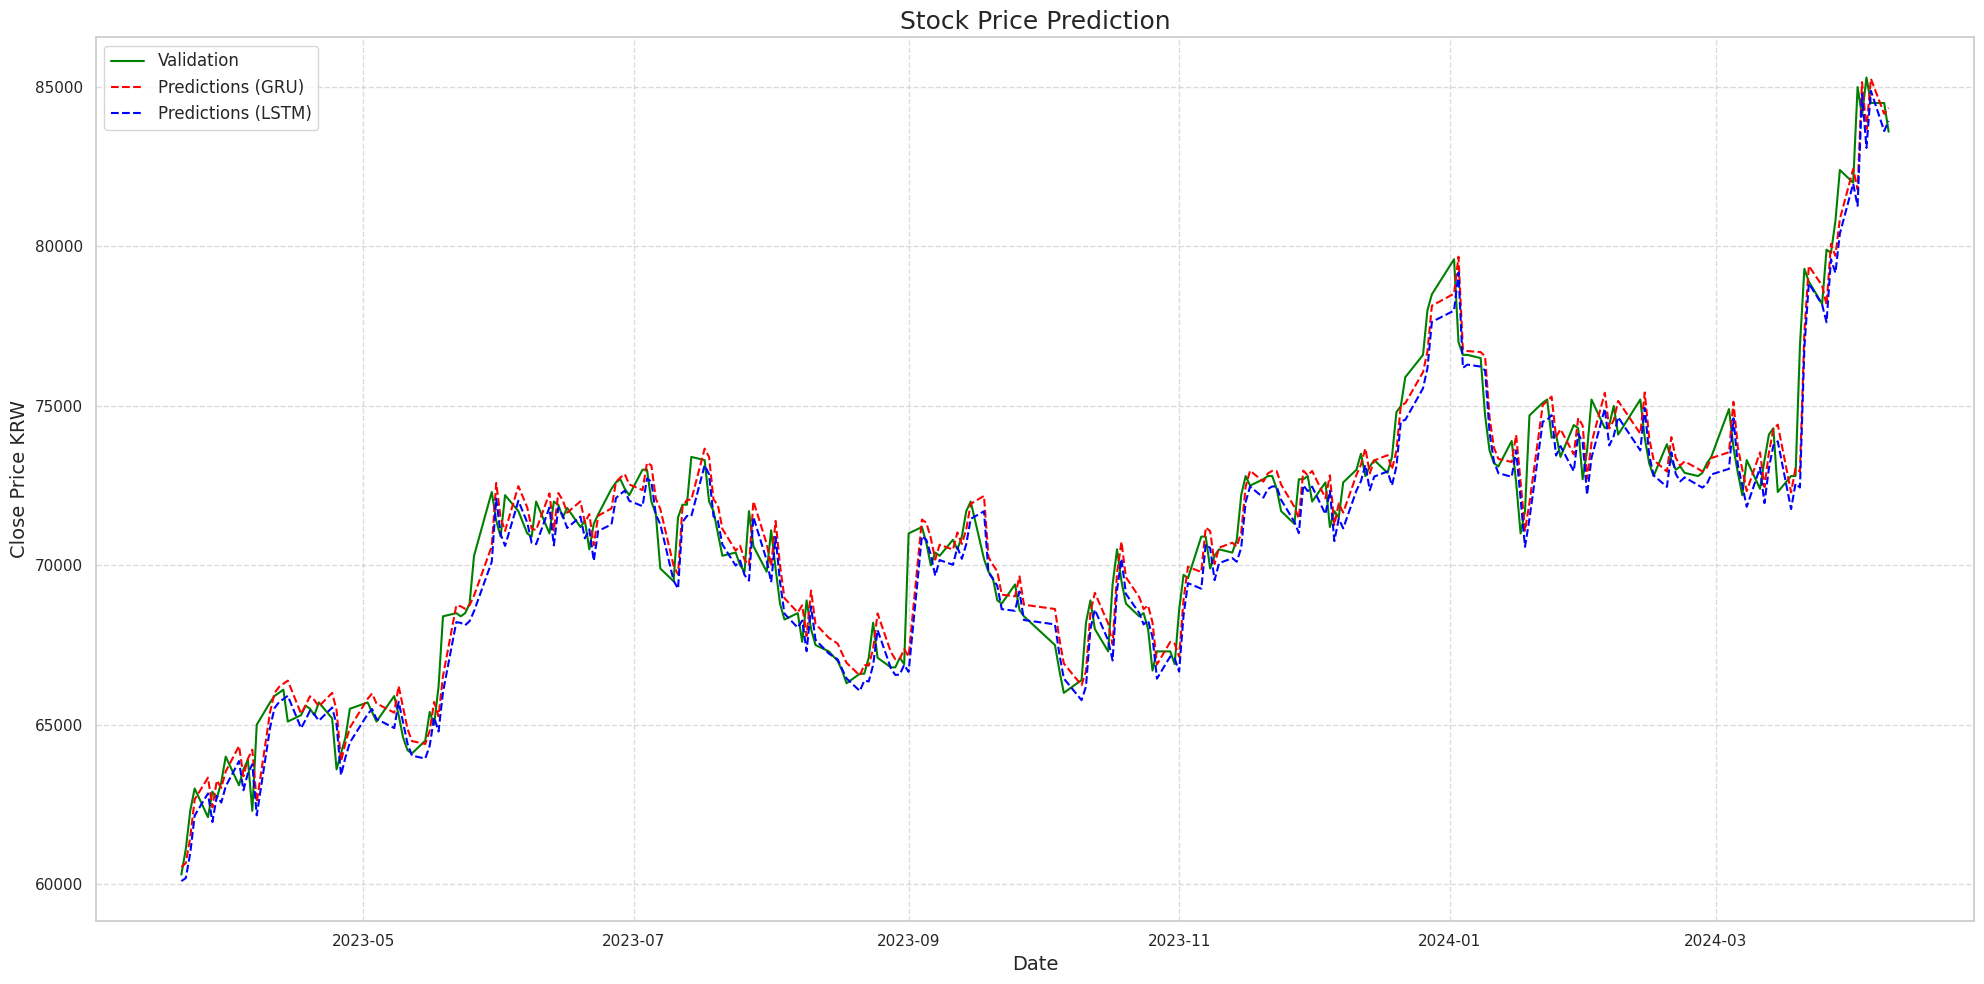

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot validation data and GRU predictions
ax.plot(test_dates, df.loc[test_dates, 'Close'], color='green', label='Validation')
ax.plot(test_dates, y_pred_GRU, color='red', linestyle='--', label='Predictions (GRU)')

# Plot LSTM predictions
ax.plot(test_dates, y_pred_LSTM, color='blue', linestyle='--', label='Predictions (LSTM)')

plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price KRW', fontsize=14)

plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

## Residual comparison

- Full Dataframe of all predictions and residuals

In [ ]:
compare_df = pd.DataFrame(
        {
        'y_test(Actual)' : df.loc[test_dates,'Close'].values ,
        'y_Pred_LSTM' : y_pred_LSTM.flatten() ,
        'y_Pred_GRU' : y_pred_GRU.flatten()
        }
    )
compare_df.set_index(test_dates, inplace = True)
compare_df['Residuals_LSTM'] = compare_df['y_Pred_LSTM'] - compare_df['y_test(Actual)']
compare_df['Residuals_GRU'] = compare_df['y_Pred_GRU'] - compare_df['y_test(Actual)']
compare_df

,y_test(Actual),y_Pred_LSTM,y_Pred_GRU,Residuals_LSTM,Residuals_GRU
Date,,,,,
2023-03-21,60300,60096.289062,60538.140625,-203.710938,238.140625
2023-03-22,61100,60190.363281,60657.992188,-909.636719,-442.007812
2023-03-23,62300,60972.457031,61461.828125,-1327.542969,-838.171875
2023-03-24,63000,62153.132812,62656.796875,-846.867188,-343.203125
2023-03-27,62100,62843.839844,63339.613281,743.839844,1239.613281
...,...,...,...,...,...
2024-04-03,84100,84785.218750,85154.273438,685.218750,1054.273438
2024-04-04,85300,83092.632812,83679.640625,-2207.367188,-1620.359375
2024-04-05,84500,84881.906250,85262.203125,381.906250,762.203125


- Scatter plot of predictions vs y_test

Text(0, 0.5, 'Predicted')

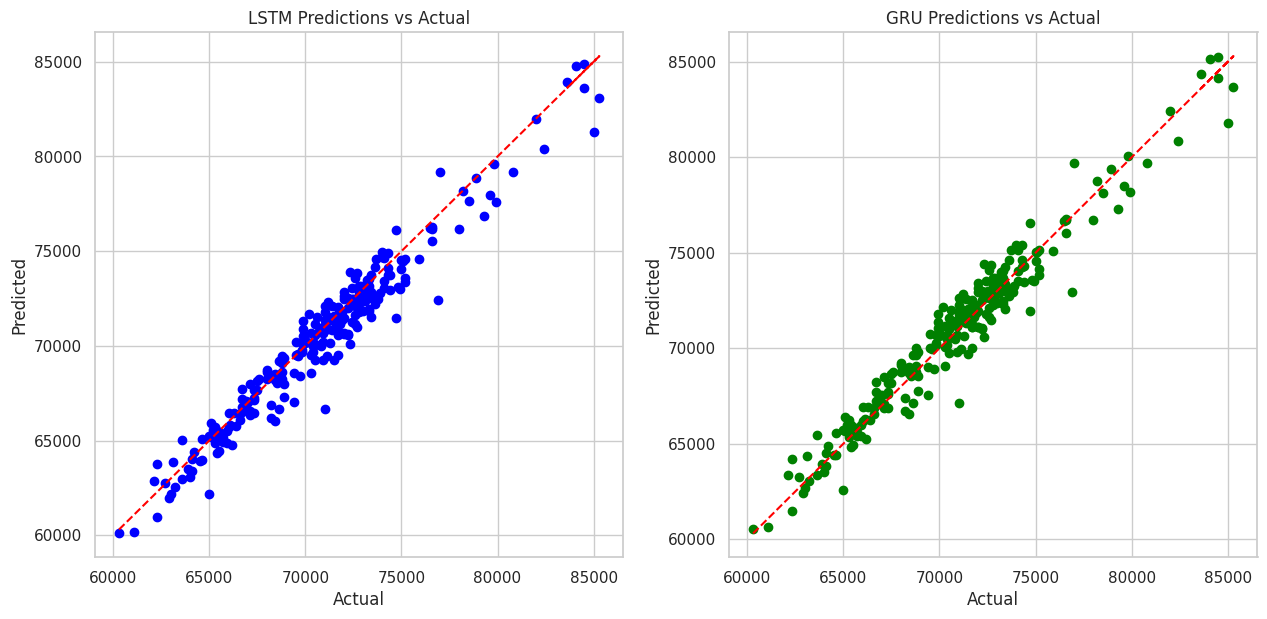

In [ ]:
plt.figure(figsize=(15, 15))

# Scatter plot for y_pred_LSTM vs y_test
plt.subplot(2, 2, 1)
plt.scatter(compare_df['y_test(Actual)'], compare_df['y_Pred_LSTM'], color='blue')
plt.plot(compare_df['y_test(Actual)'], compare_df['y_test(Actual)'], color='red', linestyle='--')  # Diagonal line for reference
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Scatter plot for y_pred_GRU vs y_test
plt.subplot(2, 2, 2)
plt.scatter(compare_df['y_test(Actual)'], compare_df['y_Pred_GRU'], color='green')
plt.plot(compare_df['y_test(Actual)'], compare_df['y_test(Actual)'], color='red', linestyle='--')  # Diagonal line for reference
plt.title('GRU Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

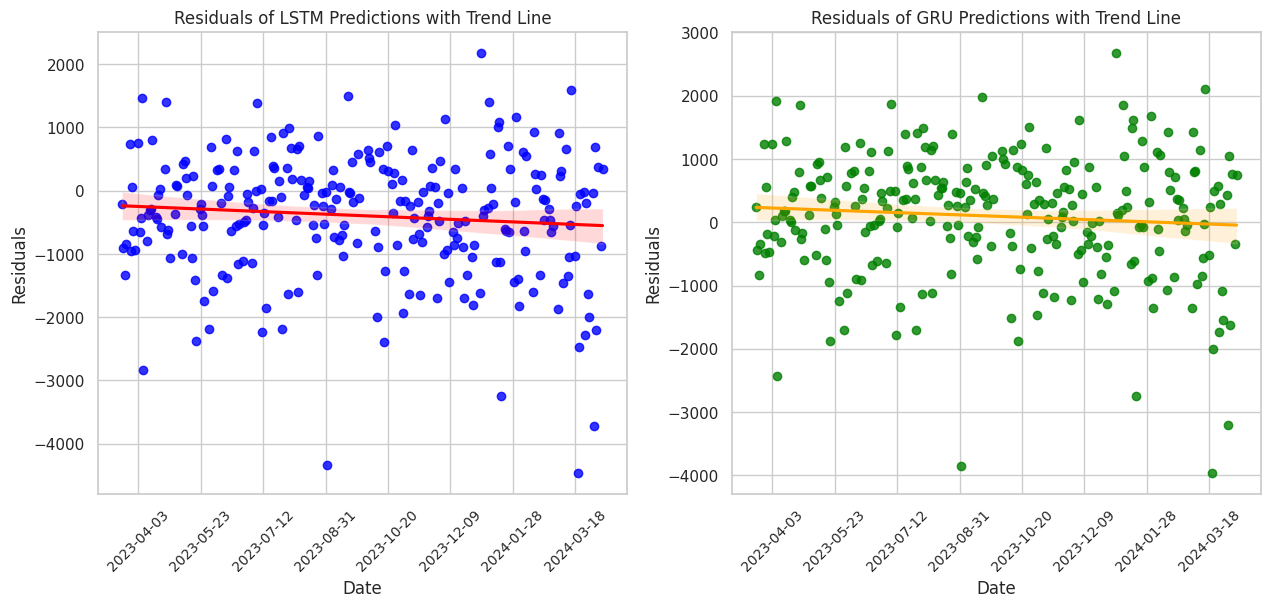

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(15, 15))

# Scatter plot with trend line for LSTM residuals
plt.subplot(2, 2, 1)
sns.regplot(x=mdates.date2num(compare_df.index), y='Residuals_LSTM', data=compare_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Residuals of LSTM Predictions with Trend Line')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=10)

# Scatter plot with trend line for GRU residuals
plt.subplot(2, 2, 2)
sns.regplot(x=mdates.date2num(compare_df.index), y='Residuals_GRU', data=compare_df, scatter_kws={'color': 'green'}, line_kws={'color': 'orange'})
plt.title('Residuals of GRU Predictions with Trend Line')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=10)

plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots

plt.show()

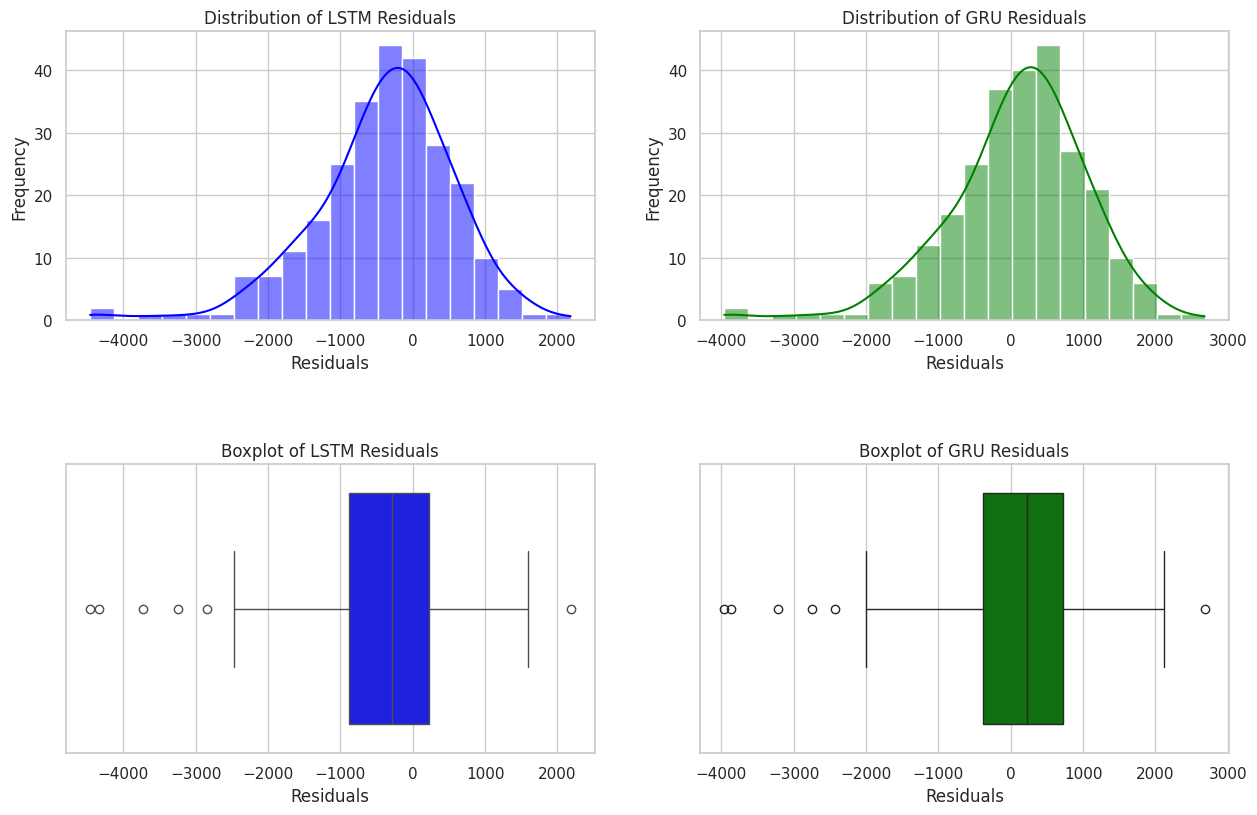

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(15, 15))

# Distribution plot for LSTM residuals
plt.subplot(3, 2, 1)
sns.histplot(compare_df['Residuals_LSTM'], kde=True, color='blue', bins=20)
plt.title('Distribution of LSTM Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Distribution plot for GRU residuals
plt.subplot(3, 2, 2)
sns.histplot(compare_df['Residuals_GRU'], kde=True, color='green', bins=20)
plt.title('Distribution of GRU Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Boxplot for LSTM residuals
plt.subplot(3, 2, 3)
sns.boxplot(x=compare_df['Residuals_LSTM'], color='blue')
plt.title('Boxplot of LSTM Residuals')
plt.xlabel('Residuals')

# Boxplot for GRU residuals
plt.subplot(3, 2, 4)
sns.boxplot(x=compare_df['Residuals_GRU'], color='green')
plt.title('Boxplot of GRU Residuals')
plt.xlabel('Residuals')

plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots

plt.show()

# FORECASTING

### Stock's closing price for next 10 days

- Here, I have used the GRU model that I trained to predict the price of Samsung stock for next 10 days.

1/1 [==============================] - 0s 55ms/step


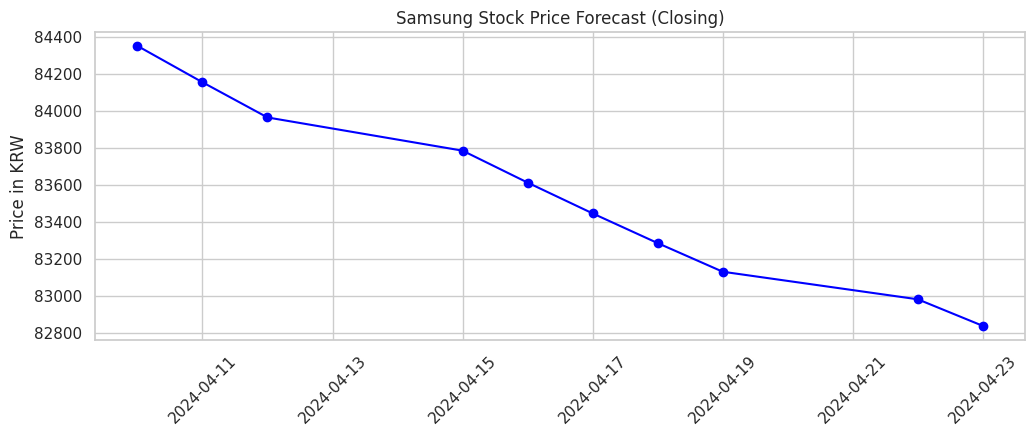

In [ ]:
recursive_predictions = []
recursive_dates = np.array(pd.date_range('2024-04-10', periods = 10, freq='B'))
last_window = x_test[-1]

for target_date in recursive_dates:
    #print(scaler.inverse_transform(last_window))
    next_prediction = model_GRU.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    new_window = list(last_window[1:])
    new_window.append(next_prediction)
    new_window = np.array(new_window)
    last_window = new_window

recursive_predictions = scaler.inverse_transform(recursive_predictions)

GRU_predictions = pd.DataFrame({'Date' : recursive_dates , 'Forecasted Price' : recursive_predictions.flatten()})
GRU_predictions

plt.figure(figsize = (12,4))

plt.plot(GRU_predictions['Date'] , GRU_predictions['Forecasted Price'] , marker = 'o' , color = 'blue')
plt.title('Samsung Stock Price Forecast (Closing)')
plt.ylabel('Price in KRW')
plt.xticks(rotation=45)
plt.show()

# CONCLUSION

- Based on the performance metrics obtained from the LSTM and GRU models for predicting Samsung stock prices, it is evident that both models exhibit strong predictive capabilities.

- The LSTM model achieved a mean absolute error (MAE) of approximately 759, a root mean squared error (RMSE) of 1038, and an r-squared score (R2) of 0.945. On the other hand, the GRU model resulted in a MAE of 733, RMSE of 964, and r-squared of 0.953.

- Visual inspection of the predicted stock prices against actual values indicates that both models capture the underlying patterns effectively.
However, a closer examination of the residuals reveals that the GRU model demonstrates slightly lower error rates and a more symmetrical distribution of residuals. Along with the better r-squared value, this suggests that the GRU model outperforms the LSTM model in terms of predictive accuracy.

- The GRU model appears to be the preferred choice for guiding investment decisions due to its superior performance. Additionally, it's worth noting that while the models provide valuable insights, there are external factors such as geopolitical events, economic policies, and unexpected market shifts that they cannot predict. For instance, sudden regulatory changes or global economic downturns can significantly impact stock prices, and these are aspects beyond the scope of the model's predictive abilities.

- Caution is advised when interpreting the forecast, and it's essential to consider a holistic view of the market landscape before making investment decisions. Nonetheless, further experimentation and fine-tuning could potentially enhance the predictive capabilities of both models even further.